In [1]:
import pandas as pd
print(pd.__version__)
import csv, sys, time
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import scipy.stats as sp
import matplotlib.pyplot as plt
import wordcloud
import seaborn as sns
import matplotlib.cm as cm
import string, re
%matplotlib inline

1.1.4


In [2]:
# Function to define a sub-subplot
# Pulling from here: https://stackoverflow.com/questions/17458580/
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height],facecolor=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    subax.spines['right'].set_color('none')
    subax.spines['top'].set_color('none')
    return subax

# Fig 1: Publication and sources over time ('clouds' AND 'climate') 
Show the total count per year of publications discussing 'clouds' and 'climate' in environmental and planetary sciences. First read in all data via a csv generated through a Scopus search. Then group these citations by years and count the total publications and *unique* sources per year and perform an exponential fit to each. 

In [3]:
# Reads in results for the search <clouds AND climate>. 11343 entries.
scopus = pd.read_csv('scopus-clouds-and-climate.csv')
# We only want the trends over the past 50 years.
scopus = scopus[(scopus['Year'] >= 1970)]

# Count the number of titles per year.
title_per_yr = scopus.groupby('Year').count()[['Title']]
print('How many publications per year on average in the following decades?')
print('1980-1990 mean: ' + str(title_per_yr.loc[1980:1990].mean()))
print('1990-2000 mean: ' + str(title_per_yr.loc[1990:2000].mean()))
print('2000-2010 mean: ' + str(title_per_yr.loc[2000:2010].mean()))
print('2010-2020 mean: ' + str(title_per_yr.loc[2010:2020].mean()))

How many publications per year on average in the following decades?
1980-1990 mean: Title    27.090909
dtype: float64
1990-2000 mean: Title    114.454545
dtype: float64
2000-2010 mean: Title    293.272727
dtype: float64
2010-2020 mean: Title    659.545455
dtype: float64


In [21]:
# Count the number of unique sources per year. Combined Journal of Geophysical Research Atmospheres and Journal of Geophysical Research first.
jgr_combined = scopus
jgr_combined['Source title'].replace({'Journal of Geophysical Research Atmospheres': 'Journal of Geophysical Research'},inplace=True)
sources_per_yr = jgr_combined.groupby('Year')['Source title'].nunique()
sources_per_yr.rename('Unique source number',inplace=True)
print('How many unique sources were there in the 1980s / 1990s / 2000s / 2010s?')
sources0 = jgr_combined[(jgr_combined['Year'] >= 1970) & (jgr_combined['Year'] < 1980)]['Source title']
sources1 = jgr_combined[(jgr_combined['Year'] >= 1980) & (jgr_combined['Year'] < 1990)]['Source title']
sources2 = jgr_combined[(jgr_combined['Year'] >= 1990) & (jgr_combined['Year'] < 2000)]['Source title']
sources3 = jgr_combined[(jgr_combined['Year'] >= 2000) & (jgr_combined['Year'] < 2010)]['Source title']
sources4 = jgr_combined[(jgr_combined['Year'] >= 2010) & (jgr_combined['Year'] < 2020)]['Source title']
print(sources1.nunique(),sources2.nunique(),sources3.nunique(),sources4.nunique())
print('Which three sources were the most common in each decade?')
print('In the 1970s:')
print(sources0.value_counts()[:6])
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('In the 1980s:')
print(sources1.value_counts()[:6])
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('In the 1990s:')
print(sources2.value_counts()[:5])
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('In the 2000s:')
print(sources3.value_counts()[:5])
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('In the 2010s:')
print(sources4.value_counts()[:5])
#print(scopus[(scopus['Year'] >= 1970) & (scopus['Year'] < 2019)]['Source title'].value_counts()[:5])

How many unique sources were there in the 1980s / 1990s / 2000s / 2010s?
114 192 277 495
Which three sources were the most common in each decade?
In the 1970s:
Atmospheric Environment (1967)                                    5
Agricultural Meteorology                                          3
Quarterly Journal of the Royal Meteorological Society             2
Water, Air, and Soil Pollution                                    2
Archiv für Meteorologie, Geophysik und Bioklimatologie Serie B    2
International Journal of Biometeorology                           1
Name: Source title, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
In the 1980s:
Journal of the Atmospheric Sciences                      25
[No title available]                                     20
Advances in Space Research                               15
Journal of Geophysical Research                          14
Atmospheric Research                                      7
Quarterly Journal of the Royal Meteorologica

In [5]:
# Logarithmic fit for these search results. 
def exponential(x, a, b):
    return a*2**(b*x)

# Find indices corresponding to 1970 and 2019.
ii = np.argwhere(title_per_yr.index == 1970)[0][0]
jj = np.argwhere(title_per_yr.index == 2019)[0][0]
yr = title_per_yr.index[ii:jj].values   # pandas.core.indexes.numeric.Int64Index
pars, _ = curve_fit(f=exponential, xdata=yr-1970, ydata=title_per_yr['Title'].iloc[ii:jj].values)
pars2, _ = curve_fit(f=exponential, xdata=yr-1970, ydata=sources_per_yr.iloc[ii:jj].values)

# Linear fit for these search results.
def lin(x, a, b):
    return a*x + b

# Non-NaN propagating standard error
def sem_nonan(arr):
    return sp.sem(arr,nan_policy='omit')

# Calculate the average page count per years, filtering for Document Type = Article.
scopus['Page end'] = pd.to_numeric(scopus['Page end'],errors='coerce') 
scopus['Page start'] = pd.to_numeric(scopus['Page start'],errors='coerce')
scopus['Page count'] = scopus['Page end'].subtract(scopus['Page start'])

a = scopus.groupby('Year')['Page count'].mean()
b = scopus.groupby('Year')['Page count'].agg(sem_nonan)
c = scopus.groupby('Year')['Page count'].agg(np.std)
# This expression omits the outlier in 2011.
avg_page_count = a[a.between(a.quantile(0.05),a.quantile(0.95))]
sterr_page_count = b[a.between(a.quantile(0.05),a.quantile(0.95))]
stdev_page_count = c[a.between(a.quantile(0.05),a.quantile(0.95))]

# Find the indices corresponding to 1970 and 2019.
ii = np.argwhere(avg_page_count.index == 1970)[0][0]
jj = np.argwhere(avg_page_count.index == 2019)[0][0]
yr2 = avg_page_count.index[ii:jj].values   # pandas.core.indexes.numeric.Int64Index

pars3, _ = curve_fit(f=lin, xdata=yr2-1970, ydata=avg_page_count.iloc[ii:jj].values)

In [6]:
# We start from 1980 for Open Access designation because 1970-1979 is almost empty.
perc_open_access = np.zeros((2020-1980))
for i in np.arange(1980,2020):
    yr_len = len(scopus[scopus['Year'] == i])
    if yr_len != 0:
        sub = scopus[(scopus['Year']==i) & (scopus['Access Type']=='Open Access')]
        perc_open_access[i-1980] = float(len(sub)) / float(yr_len) * 100.
    else:
        perc_open_access[i-1980] = 0

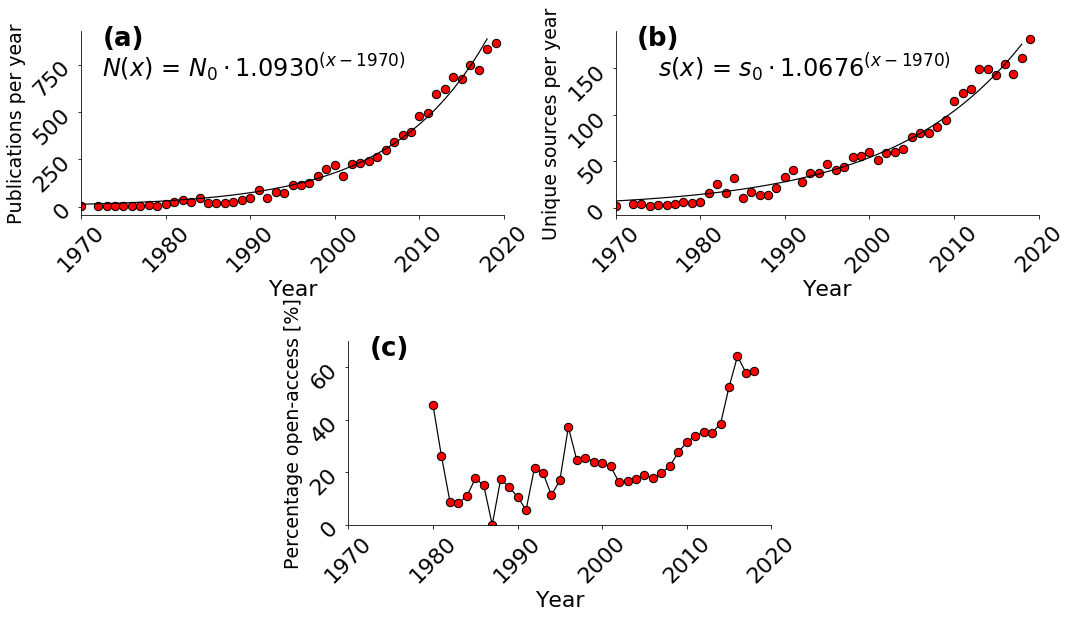

In [7]:
#%%capture
fs = 22
fig1 = plt.figure(figsize=(15,8.5)) #constrained_layout=True,

gs = fig1.add_gridspec(2,4)
f1_ax1 = fig1.add_subplot(gs[0,:2])
# The -2 index here is to plot only up to 2019, omitting 2020 and 2021
f1_ax1.scatter(title_per_yr[:-2].index.values,title_per_yr['Title'][:-2],s=70,c='r',edgecolor='k')
f1_ax1.plot(yr,pars[0]*2**(pars[1]*(yr-1970)),color='k',linewidth=1.2)
f1_ax1.set_xlabel('Year',fontsize=fs)
f1_ax1.set_ylabel('Publications per year',fontsize=fs-3)
f1_ax1.set_xlim([1970,2020])
f1_ax1.tick_params(axis='both',labelsize=fs, rotation=45)
f1_ax1.text(0.05,0.92,'(a)',weight='bold',fontsize=fs+4,transform=f1_ax1.transAxes)
f1_ax1.spines['top'].set_color('none')
f1_ax1.spines['right'].set_color('none')
growthrate = 2**(pars[1])
f1_ax1.text(0.05,0.75,r'$N(x)$ = $N_0\cdot$%.4f$^{(x-1970)}$'%(growthrate),fontsize=fs+2,transform=f1_ax1.transAxes)

f1_ax2 = fig1.add_subplot(gs[0,2:])
f1_ax2.scatter(sources_per_yr[:-2].index.values,sources_per_yr[:-2],s=70,c='r',edgecolor='k')
f1_ax2.plot(yr,pars2[0]*2**(pars2[1]*(yr-1970)),color='k',linewidth=1.2)
f1_ax2.set_xlabel('Year',fontsize=fs)
f1_ax2.set_ylabel('Unique sources per year',fontsize=fs-3)
f1_ax2.set_xlim([1970,2020])
f1_ax2.tick_params(axis='both',labelsize=fs, rotation=45)
f1_ax2.spines['top'].set_color('none')
f1_ax2.spines['right'].set_color('none')
f1_ax2.text(0.05,0.92,'(b)',weight='bold',fontsize=fs+4,transform=f1_ax2.transAxes)
growthrate = 2**(pars2[1])
f1_ax2.text(0.1,0.75,r'$s(x)$ = $s_0\cdot$%.4f$^{(x-1970)}$'%(growthrate),fontsize=fs+2,transform=f1_ax2.transAxes)

f1_ax3 = fig1.add_subplot(gs[1,1:3])
f1_ax3.plot(np.arange(1980,2019),perc_open_access[:-1],color='k',lw=1.2,zorder=-1)
f1_ax3.scatter(np.arange(1980,2019),perc_open_access[:-1],s=70,c='r',edgecolor='k',zorder=1)
f1_ax3.tick_params('both',labelsize=fs,rotation=45)
f1_ax3.set_ylim([0,70])
f1_ax3.set_xlim([1970,2020])
f1_ax3.set_ylabel('Percentage open-access [%]',fontsize=fs-3)
f1_ax3.set_xlabel('Year',fontsize=fs)
f1_ax3.text(0.05,0.92,'(c)',weight='bold',fontsize=fs+4,transform=f1_ax3.transAxes)
f1_ax3.spines['right'].set_color('none')
f1_ax3.spines['top'].set_color('none')

plt.tight_layout()
#fig1.savefig('publication-growth.pdf',bbox_inches='tight')

In [8]:
# How do the clouds and climate publications compare to those in other climate subdisciplines?

######################## OCEAN ###########################
scopus1 = pd.read_csv('scopus-ocean-climate-1.csv')
scopus2 = pd.read_csv('scopus-ocean-climate-2.csv')
scopus3 = pd.read_csv('scopus-ocean-climate-3.csv')
scopus = pd.concat([scopus1, scopus2, scopus3])
title_per_yr = scopus.groupby('Year').count()[['Title']]

ii = np.argwhere(title_per_yr.index == 1970)[0][0]
par, _ = curve_fit(f=exponential, xdata=np.arange(50), ydata=title_per_yr['Title'].iloc[ii:].values)
growthrate = 2**(par[1])
print(growthrate)

######################## CARBON CYCLE ###########################
scopus = pd.read_csv('scopus-carbon-cycle-climate.csv')
title_per_yr = scopus.groupby('Year').count()[['Title']]
title_per_yr_values = title_per_yr.values

# Find indices corresponding to 1970 and 2019.
ii = np.argwhere(title_per_yr.index >= 1970)[0][0]
jj = np.argwhere(title_per_yr.index == 2020)[0][0]
title_per_yr_values = title_per_yr_values[ii:jj]

# No publications in the early 1970s so we fill these with 0s.
for i in np.arange(50):
    if i+1970 not in title_per_yr.index:
        title_per_yr_values = np.insert(title_per_yr_values,i,0)
par, _ = curve_fit(f=exponential, xdata=np.arange(50), ydata=title_per_yr_values)
growthrate = 2**(par[1])
print(growthrate)

#################### LAND SURFACE ###########################
scopus = pd.read_csv('scopus-land-surface-climate.csv')
title_per_yr = scopus.groupby('Year').count()[['Title']]
title_per_yr_values = title_per_yr.values

# Find indices corresponding to 1970 and 2019.
ii = np.argwhere(title_per_yr.index >= 1970)[0][0]
jj = np.argwhere(title_per_yr.index == 2020)[0][0]
title_per_yr_values = title_per_yr_values[ii:jj]

# Some years in the early 1970s with no publications so we fill these with 0s.
for i in np.arange(50):
    if i+1970 not in title_per_yr.index:
        title_per_yr_values = np.insert(title_per_yr_values,i,0)

par, _ = curve_fit(f=exponential, xdata=np.arange(50), ydata=title_per_yr_values)
growthrate = 2**(par[1])
print(growthrate)

#################### AIR POLLUTION ###########################
scopus = pd.read_csv('scopus-air-pollution-climate.csv')
title_per_yr = scopus.groupby('Year').count()[['Title']]

# Find indices corresponding to 1970 and 2019.
ii = np.argwhere(title_per_yr.index == 1970)[0][0]
jj = np.argwhere(title_per_yr.index == 2020)[0][0]
title_per_yr_values = title_per_yr.values[ii:jj][:,0]

par, _ = curve_fit(f=exponential, xdata=np.arange(50), ydata=title_per_yr_values)
growthrate = 2**(par[1])
print(growthrate)

#################### CRYOSPHERE ###########################
scopus = pd.read_csv('scopus-cryosphere-climate.csv')
title_per_yr = scopus.groupby('Year').count()[['Title']]
title_per_yr_values = title_per_yr.values

# Find indices corresponding to 1970 and 2019.
ii = np.argwhere(title_per_yr.index >= 1970)[0][0]
jj = np.argwhere(title_per_yr.index == 2020)[0][0]
title_per_yr_values = title_per_yr_values[ii:jj]

# Some years in the early 1970s with no publications so we fill these with 0s.
for i in np.arange(50):
    if i+1970 not in title_per_yr.index:
        title_per_yr_values = np.insert(title_per_yr_values,i,0)

par, _ = curve_fit(f=exponential, xdata=np.arange(50), ydata=title_per_yr_values)
growthrate = 2**(par[1])
print(growthrate)

#################### BIOSPHERE ###########################
scopus = pd.read_csv('scopus-biosphere-climate.csv')
title_per_yr = scopus.groupby('Year').count()[['Title']]
title_per_yr_values = title_per_yr.values

# Find indices corresponding to 1970 and 2019.
ii = np.argwhere(title_per_yr.index >= 1970)[0][0]
jj = np.argwhere(title_per_yr.index == 2020)[0][0]
title_per_yr_values = title_per_yr_values[ii:jj]

# Some years in the early 1970s with no publications so we fill these with 0s.
for i in np.arange(50):
    if i+1970 not in title_per_yr.index:
        title_per_yr_values = np.insert(title_per_yr_values,i,0)

par, _ = curve_fit(f=exponential, xdata=np.arange(50), ydata=title_per_yr_values)
growthrate = 2**(par[1])
print(growthrate)

1.091730785949207
1.1221729199546475
1.1102860645189268
1.0849311349447095
1.1462476279380172
1.0806386438645916


# Fig 2: Publication and citation correlation
If a journal publishes more, is it also cited more?

Publication to citation conversion: 30.192468504153602
Publication to citation conversion: 27.54315760512358
Publication to citation conversion: 59.68593155893535
Publication to citation conversion: 16.506878071752148
Publication to citation conversion: 33.43210877733627


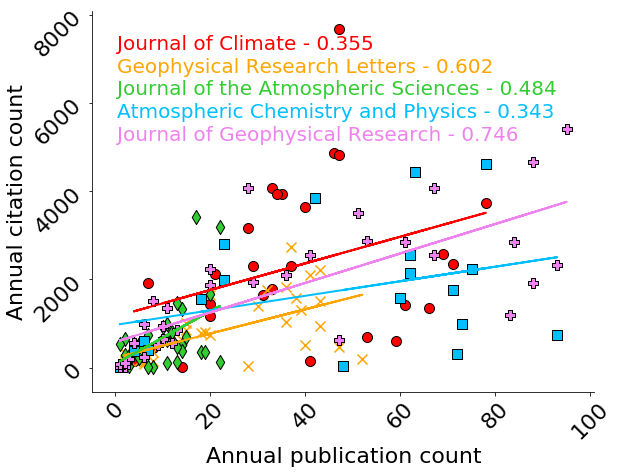

In [23]:
# Group by both journal and year with the JGR names combined
count_per_yr_journal = jgr_combined.groupby(['Source title','Year'])
countt = count_per_yr_journal.count()
summ = count_per_yr_journal.sum()
journals = ['Journal of Climate', 'Geophysical Research Letters', 'Journal of the Atmospheric Sciences',
           'Atmospheric Chemistry and Physics', 'Journal of Geophysical Research']

fig2 = plt.figure(figsize=(9,7))
shape = ['o','x','d','s','P']
farbe = ['r','orange','limegreen','deepskyblue','violet']
for j, s, f, i in zip(journals, shape, farbe, np.arange(5)):
    plt.scatter(countt.loc[j]['Title'], summ.loc[j]['Cited by'],c=f,s=100,marker=s,edgecolor='k',zorder=0)
    m, b = np.polyfit(countt.loc[j]['Title'], summ.loc[j]['Cited by'], 1)
    print('Publication to citation conversion: ' + str(m))
    r2 = np.corrcoef(countt.loc[j]['Title'], summ.loc[j]['Cited by'])[0,1]
    plt.plot(countt.loc[j]['Title'], m*countt.loc[j]['Title']+b, color=f, linewidth=2, zorder=1) 
    plt.text(0.05,0.9-i*0.06,j+' - '+"{:1.3f}".format(r2),c=f,fontsize=fs-2,transform=plt.gca().transAxes)
plt.xlabel('Annual publication count',fontsize=fs)
plt.ylabel('Annual citation count',fontsize=fs)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().tick_params('both',labelsize=fs,rotation=45)

#fig2.savefig('publication-citation.pdf',bbox_inches='tight')
plt.show()

# Fig 3: Citation distributions

In [12]:
# Pre-programmed element-wise function for Kullback-Leibler divergence
from scipy.special import kl_div

# Reads in results for the search <clouds AND climate>. 11343 entries.
scopus = pd.read_csv('scopus-clouds-and-climate.csv')

# All years 1990-2020 and citation numbers between 1 and 10**(2.25)
start_yr = 1990
yr = np.arange(start_yr,2020)
vv = np.logspace(0,2.25,15)  # Using 15 bins, we have to start from 1990 to have non-inf div_KL
hvals = np.zeros((len(yr),len(vv)-1))
for i, y in enumerate(yr):
    vals = scopus['Cited by'].loc[scopus['Year'].between(y,y+1,inclusive=True)].dropna().to_numpy()
    # Histogram of these citation values
    hvals[i],_ = np.histogram(vals,bins=vv)
    
kl = np.zeros((len(yr),))
for i in np.arange(2020-start_yr-1):
    kl[i] = np.nansum(kl_div(hvals[i+1],hvals[i]))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

kl_rolling_mean = moving_average(kl,5)
yr_rolling_mean = moving_average(yr,5)
for i, k in enumerate(kl_rolling_mean):
    print('Rolling mean KL div' + str(i+start_yr) + '-' + str(i+1+start_yr) + ' = ' + str(k))

Rolling mean KL div1990-1991 = 11.844319667181999
Rolling mean KL div1991-1992 = 13.50846460357061
Rolling mean KL div1992-1993 = 12.39372319873841
Rolling mean KL div1993-1994 = 15.00695416936179
Rolling mean KL div1994-1995 = 12.795691509177914
Rolling mean KL div1995-1996 = 12.091901250005302
Rolling mean KL div1996-1997 = 10.528865335296624
Rolling mean KL div1997-1998 = 10.082893998316651
Rolling mean KL div1998-1999 = 6.555340764910606
Rolling mean KL div1999-2000 = 7.540023132423201
Rolling mean KL div2000-2001 = 8.425994350243005
Rolling mean KL div2001-2002 = 10.923495709240578
Rolling mean KL div2002-2003 = 12.237482877641671
Rolling mean KL div2003-2004 = 11.942868851954891
Rolling mean KL div2004-2005 = 12.479109934076273
Rolling mean KL div2005-2006 = 13.84813202790286
Rolling mean KL div2006-2007 = 13.561733807181966
Rolling mean KL div2007-2008 = 15.47257977165469
Rolling mean KL div2008-2009 = 20.03339253417982
Rolling mean KL div2009-2010 = 20.607473563825295
Rolling m

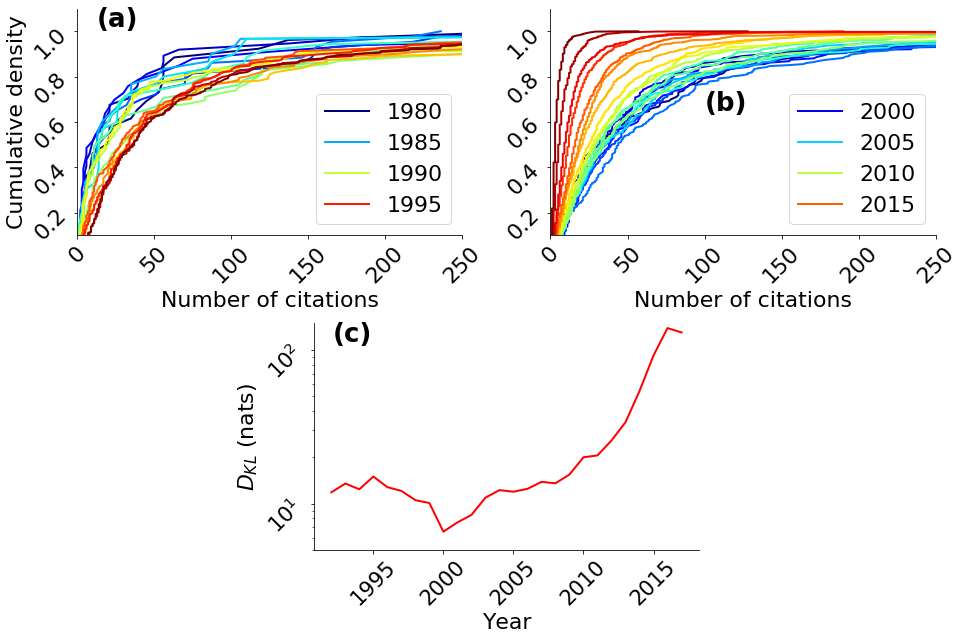

In [20]:
fs = 22
fig3 = plt.figure(figsize=(13.5,9))

gs = fig3.add_gridspec(2,4)
# Bins and decade 'dividers' for the histogram of citations. No kernel density estimate below (kde=False).
xx = np.linspace(0,200,30)

f3_ax1 = fig3.add_subplot(gs[0,:2])
yr = np.arange(1980,1998)
farbe = plt.cm.jet(np.linspace(0,1,len(yr)))
for i, y in enumerate(yr):
    vals = scopus['Cited by'].loc[scopus['Year'].between(y,y+1,inclusive=True)].dropna().to_numpy()
    # sort the data
    vals_sorted = np.sort(vals)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(vals)) / (len(vals) - 1)
    if y%5 == 0:
        f3_ax1.plot(vals_sorted,p,linewidth=2,label=str(y),color=farbe[i])
    else:
        f3_ax1.plot(vals_sorted,p,linewidth=2,label='_nolegend_',color=farbe[i])

f3_ax1.legend(fontsize=fs,loc='lower right')
f3_ax1.set_ylim([0.1,1.1])
f3_ax1.set_xlim([0,250])
f3_ax1.tick_params('both',labelsize=fs,rotation=45)
f3_ax1.set_ylabel('Cumulative density',fontsize=fs)
f3_ax1.set_xlabel('Number of citations',fontsize=fs)
f3_ax1.text(0.05,0.92,'(a)',weight='bold',fontsize=fs+4,transform=f3_ax1.transAxes)
f3_ax1.spines['right'].set_color('none')
f3_ax1.spines['top'].set_color('none')

f3_ax2 = fig3.add_subplot(gs[0,2:])
yr = np.arange(1998,2020)
farbe = plt.cm.jet(np.linspace(0,1,len(yr)))
for i,y in enumerate(yr):
    #vals = scopus['Cited by'].loc[scopus['Year'].between(y,y+3,inclusive=True)].dropna().to_numpy()
    vals = scopus['Cited by'].loc[scopus['Year'] == y].dropna().to_numpy()
    # sort the data
    vals_sorted = np.sort(vals)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(vals)) / (len(vals) - 1)
    if y%5 == 0:
        f3_ax2.plot(vals_sorted,p,linewidth=2,label=str(y),color=farbe[i])
    else:
        f3_ax2.plot(vals_sorted,p,linewidth=2,label='_nolegend_',color=farbe[i])

f3_ax2.legend(fontsize=fs,loc='lower right')
f3_ax2.set_ylim([0.1,1.1])
f3_ax2.set_xlim([0,250])
f3_ax2.tick_params('both',labelsize=fs,rotation=45)
f3_ax2.set_xlabel('Number of citations',fontsize=fs)
f3_ax2.text(0.4,0.55,'(b)',weight='bold',fontsize=fs+4,transform=f3_ax2.transAxes)
f3_ax2.spines['right'].set_color('none')
f3_ax2.spines['top'].set_color('none')

f3_ax3 = fig3.add_subplot(gs[1,1:3])
f3_ax3.plot(yr_rolling_mean,kl_rolling_mean,lw=2,color='r')
f3_ax3.set_ylim([5,150])
f3_ax3.set_yscale('log')
f3_ax3.text(0.05,0.92,'(c)',weight='bold',fontsize=fs+4,transform=f3_ax3.transAxes)
f3_ax3.spines['right'].set_color('none')
f3_ax3.spines['top'].set_color('none')
f3_ax3.tick_params('both',labelsize=fs-1,rotation=45)
f3_ax3.set_ylabel(r'$D_{KL}$ (nats)',fontsize=fs)
f3_ax3.set_xlabel('Year',fontsize=fs)

plt.tight_layout()
fig3.savefig('citation-distributions.pdf',bbox_inches='tight')

# Fig 4 - Degrees granted and funding 
The other panels look at the citation number stratified by decade and US funding + student numbers over time. It would be nice to find data from outside the US.

In [10]:
# Doctorate degrees and funding dollars awarded in geosciences in the US.
us_deg = pd.read_csv('US-doctorates-by-field.csv')
us_yr = np.array([int(i) for i in us_deg.iloc[5].index.values[1:]])
us_deg = np.array([int(i.replace(",","")) for i in us_deg.iloc[5][1:]])

us_funding = pd.read_csv('US-research-funding-by-field.csv')
us_yr2 = np.array([int(i) for i in us_funding.iloc[12].index.values[1:]])
us_funding = np.array([int(i.replace(",","")) for i in us_funding.iloc[12][1:]])

#print('How many funding dollars per student in 1999?')
#print(us_yr[19],us_yr2[2],us_funding[19]/us_deg[19])
#print(us_yr2[19],us_funding[19])

scopus = pd.read_csv('scopus-clouds-and-climate.csv')
yr = [1980,1990,2000,2010]
print('What percentage of articles had less than 10 citations in each decade?')
for y in yr:
    cited = scopus['Cited by'].loc[scopus['Year'].between(y,y+9,inclusive=True)]
    print(len(cited[cited < 10])/len(cited)*100)

What percentage of articles had less than 10 citations in each decade?
31.07569721115538
19.30835734870317
15.40983606557377
39.67237527922561


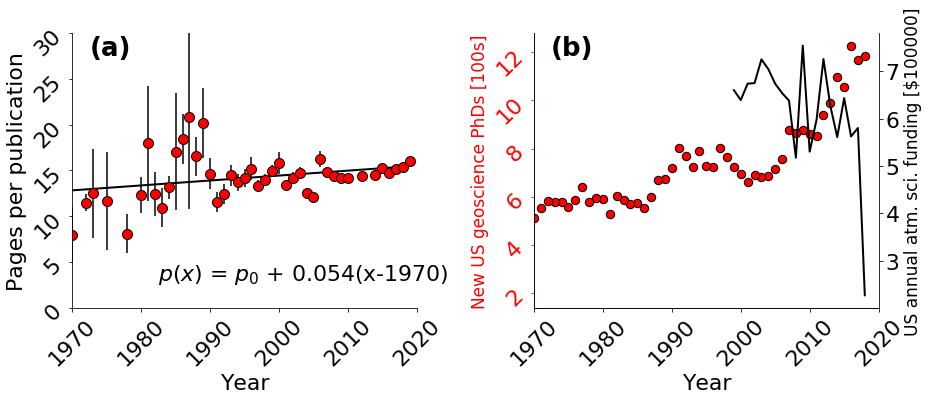

In [200]:
fs = 22
fig4 = plt.figure(figsize=(13,5.5))

gs = fig4.add_gridspec(1,2)

# Page counts
f4_ax1 = fig4.add_subplot(gs[0,0])
f4_ax1.errorbar(avg_page_count.index.values[:-1],avg_page_count[:-1],yerr=sterr_page_count[:-1],
              marker='o',color='r',markersize=10,markeredgecolor='k',ecolor='k',ls='None')
f4_ax1.plot(yr2,pars3[0]*(yr2-1970) + pars3[1],color='k',linewidth=2)
f4_ax1.set_xlabel('Year',fontsize=fs)
f4_ax1.set_ylabel('Pages per publication',fontsize=fs)
f4_ax1.set_xlim([1970,2020])
f4_ax1.set_ylim([0,30])
f4_ax1.tick_params(axis='both',labelsize=fs,rotation=45)
f4_ax1.text(0.05,0.92,'(a)',weight='bold',fontsize=fs+4,transform=f4_ax1.transAxes)
f4_ax1.text(0.25,0.1,r'$p(x)$ = $p_0$ + %.3f(x-1970)'%(pars3[0]),fontsize=fs,transform=f4_ax1.transAxes)
f4_ax1.spines['right'].set_color('none')
f4_ax1.spines['top'].set_color('none')

f4_ax2 = fig4.add_subplot(gs[0,1])
f4_ax2.scatter(us_yr,us_deg/100.,c='r',s=70,edgecolor='k')
f4_ax2.set_xlim([1970,2020])
f4_ax2.tick_params(axis='both',labelsize=fs,rotation=45)
f4_ax2.tick_params(axis='y',colors='red')
ax2 = f4_ax2.twinx()
ax2.plot(us_yr2,us_funding/100000.,'k',lw=2)
ax2.tick_params('both',labelsize=fs)
f4_ax2.set_xlabel('Year',fontsize=fs)
f4_ax2.set_ylabel('New US geoscience PhDs [100s]',color='r',fontsize=fs-5)
ax2.set_ylabel('US annual atm. sci. funding [$100000]',fontsize=fs-5) #,labelpad=-1)
f4_ax2.text(0.05,0.92,'(b)',weight='bold',fontsize=fs+4,transform=f4_ax2.transAxes)
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
f4_ax2.spines['top'].set_color('none')

plt.tight_layout()
#fig4.savefig('pages-funding.pdf',bbox_inches='tight')

# Fig 5: Plot publication numbers by impact (radiation, circulation, precipitation)
Also generate word clouds of article titles in the underlying panels. The stopwords option within the WordCloud command omits certain 'junk' / obvious words like 'using'. The last cell here is raw because it was an unneccessary attempt to omit these junk words manually... oops.

In [12]:
# Read in the dataframes concerning circulation, radiation, precipitation.
circ = pd.read_csv('clouds-climate-circulation.csv')
rad = pd.read_csv('clouds-climate-radiation.csv')
prec = pd.read_csv('clouds-climate-precipitation.csv')

# Count the number of titles per year as above for all ctrations.
circ_per_yr = circ.groupby('Year').count()[['Title']]
rad_per_yr = rad.groupby('Year').count()[['Title']]
prec_per_yr = prec.groupby('Year').count()[['Title']]

# Remove the subscript junk from the titles.
title1 = np.zeros((circ['Title'].values.shape),dtype=object)
for j,t in enumerate(circ['Title'].values):
    title1[j] = t.replace('<inf>','').replace('</inf>','')

# Write the titles to a text file.
title_write = False
if title_write == True:
    np.savetxt('cloud_circulation_title.txt',title1,fmt='%s')
    np.savetxt('cloud_radiation_title.txt',rad['Title'].values,fmt='%s')
    np.savetxt('cloud_precipitation_title.txt',prec['Title'].values,fmt='%s')

In [75]:
text = open('cloud_radiation_title.txt',encoding='utf-8').read()
woerter = ['cloud','clouds','climate','using','change','Comparison','Evaluation','effect','global','study','effects',\
          'atmospheric','changes','response','based','Part','characteristic','influence']
nuage1 = wordcloud.WordCloud(background_color='white',max_words=50,colormap=cm.autumn,
                             stopwords=list(wordcloud.STOPWORDS)+woerter,
                             min_font_size=8).generate(text)
text = open('cloud_circulation_title.txt',encoding='utf-8').read()
nuage2 = wordcloud.WordCloud(background_color='white',max_words=70,colormap=cm.summer,
                             stopwords=list(wordcloud.STOPWORDS)+woerter,
                             min_font_size=8).generate(text)
text = open('cloud_precipitation_title.txt',encoding='utf-8').read()
nuage3 = wordcloud.WordCloud(background_color='white',max_words=70,colormap=cm.cool, #cm.brg
                             stopwords=list(wordcloud.STOPWORDS)+woerter,
                             min_font_size=8).generate(text)

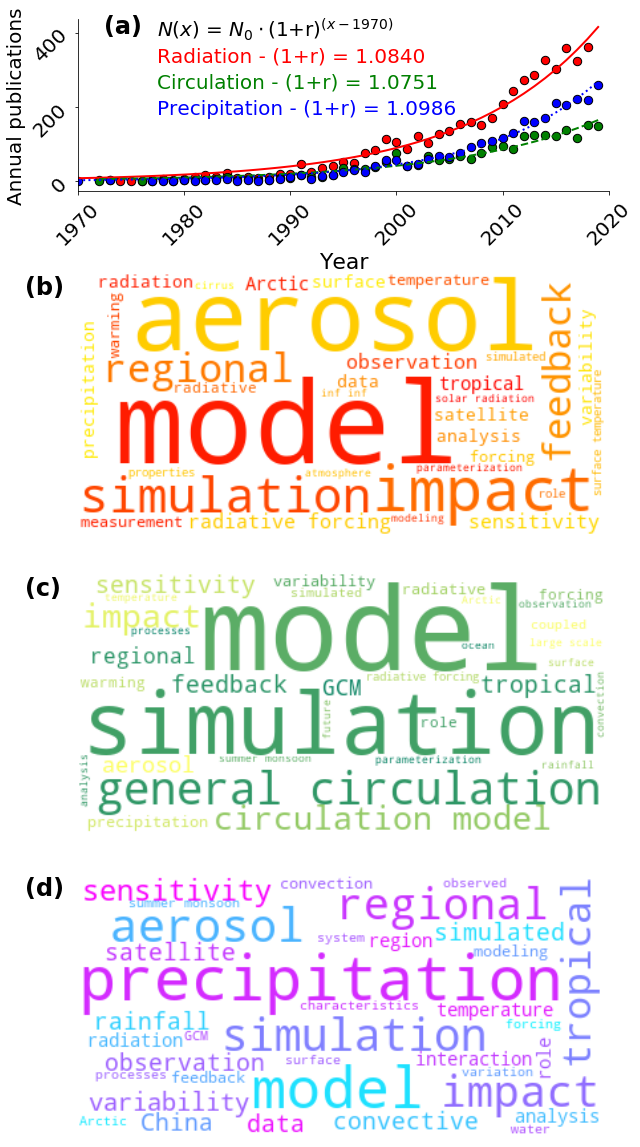

In [206]:
#%%capture
fs = 20
fig5 = plt.figure(figsize=(9,17))

gs = fig5.add_gridspec(nrows=4,ncols=1,hspace=0)
f5_ax1 = fig5.add_subplot(gs[0,0])
f5_ax1.set_aspect(0.035)
f5_ax1.scatter(rad_per_yr.index.values[:-2],rad_per_yr['Title'][:-2],color='r',s=70,edgecolor='k',
               label='Clouds, climate, and radiation')
f5_ax1.scatter(circ_per_yr.index.values[:-2],circ_per_yr['Title'][:-2],color='g',s=70,edgecolor='k',
               label='Clouds, climate, and circulation')
f5_ax1.scatter(prec_per_yr.index.values[:-2],prec_per_yr['Title'][:-2],color='b',s=70,edgecolor='k',
               label='Clouds, climate, and precipitation')

ii = np.argmin(np.abs(rad_per_yr.index.values - 1970))
jj = np.argwhere(rad_per_yr.index.values == 2020)[0][0]
yr = rad_per_yr.index[ii:jj].values   # pandas.core.indexes.numeric.Int64Index
pars, _ = curve_fit(f=exponential, xdata=yr-1970, ydata=rad_per_yr['Title'][ii:jj])
f5_ax1.plot(yr,pars[0]*2**(pars[1]*(yr-1970)),color='r',linewidth=2)
f5_ax1.text(0.15,0.9,r'$N(x)$ = $N_0\cdot$(1+r)$^{(x-1970)}$',fontsize=fs,color='k',
        transform=f5_ax1.transAxes)
growthrate = 2**(pars[1])
f5_ax1.text(0.15,0.75,'Radiation - (1+r) = ' + '{:01.4f}'.format(growthrate),fontsize=fs,color='r',
        transform=f5_ax1.transAxes)

ii = np.argmin(np.abs(circ_per_yr.index.values - 1970))
jj = np.argwhere(circ_per_yr.index.values == 2020)[0][0]
yr = circ_per_yr.index[ii:jj].values
pars, _ = curve_fit(f=exponential, xdata=yr-1970, ydata=circ_per_yr['Title'][ii:jj])
f5_ax1.plot(yr,pars[0]*2**(pars[1]*(yr-1970)),color='g',linestyle='--',linewidth=2)
growthrate = 2**(pars[1])
f5_ax1.text(0.15,0.6,'Circulation - (1+r) = ' + '{:01.4f}'.format(growthrate),fontsize=fs,color='g',
        transform=f5_ax1.transAxes)

ii = np.argmin(np.abs(prec_per_yr.index.values - 1970))
jj = np.argwhere(prec_per_yr.index == 2020)[0][0]
yr = prec_per_yr.index[ii:jj].values
pars, _ = curve_fit(f=exponential, xdata=yr-1970, ydata=prec_per_yr['Title'][ii:jj])
f5_ax1.plot(yr,pars[0]*2**(pars[1]*(yr-1970)),color='b',linestyle='dotted',linewidth=2)
growthrate = 2**(pars[1])
#print(pars[0]*2**(pars[1]*(yr-1970)))
f5_ax1.text(0.15,0.45,'Precipitation - (1+r) = ' + '{:01.4f}'.format(growthrate),fontsize=fs,color='b',
        transform=f5_ax1.transAxes)

f5_ax1.text(0.05,0.92,'(a)',weight='bold',fontsize=fs+4,transform=f5_ax1.transAxes)
f5_ax1.tick_params(axis='both',labelsize=fs,rotation=45)
f5_ax1.spines['right'].set_color('none')
f5_ax1.spines['top'].set_color('none')
f5_ax1.set_xlabel('Year',fontsize=fs+2)
f5_ax1.set_ylabel('Annual publications',fontsize=fs)
f5_ax1.set_xlim([1970,2020])
#f5_ax1.legend(loc='center left',fontsize=fs)

f5_ax2 = fig5.add_subplot(gs[1,0])
f5_ax2.imshow(nuage1, interpolation='bilinear')
f5_ax2.axis('off')
f5_ax2.text(-0.1,0.92,'(b)',weight='bold',fontsize=fs+4,transform=f5_ax2.transAxes)

f5_ax3 = fig5.add_subplot(gs[2,0])
f5_ax3.imshow(nuage2, interpolation='bilinear')
f5_ax3.axis('off')
f5_ax3.text(-0.1,0.92,'(c)',weight='bold',fontsize=fs+4,transform=f5_ax3.transAxes)
f5_ax3.autoscale_view('tight')

f5_ax4 = fig5.add_subplot(gs[3,0])
f5_ax4.imshow(nuage3, interpolation='bilinear')
f5_ax4.axis('off')
f5_ax4.text(-0.1,0.92,'(d)',weight='bold',fontsize=fs+4,transform=f5_ax4.transAxes)

plt.tight_layout()

#fig5.savefig('publications-by-impact.pdf')

# Fig 6: Plot publication numbers by chapter theme

In [207]:
# Read in csv files, add them to a single dataframe, and specify their 'Chapter'.
subthemes = ['-1-ECS-cloud-feedbacks','-2-radiative-transfer-CRE','-3-cloud-classification',\
            '-4-cloud-microphysics-parameterization','-5-aerosol-cloud-interactions-AIE',\
            '-6-primitive-equations-dynamical-core','-7-RCE-convective-organization',\
            '-8-cloud-circulation-coupling','-9-cloud-multiscale','-10-cloud-field-campaign',\
            '-11-cloud-ground-based-measurement','-12-cloud-precipitation-measurement',\
            '-13-cloud-machine-learning-causal-inference']

pubs = pd.read_csv('scopus' + subthemes[0] + '.csv')
pubs['Subtheme'] = pd.Series(np.ones(len(pubs.index)))
for i, s in enumerate(subthemes):
    if i == 0:
        continue
    else:
        # axis=0 means concatenate indices (not columns).
        temp = pd.read_csv('scopus' + s + '.csv')
        initl = len(pubs.index) 
        pubs = pd.concat([pubs, temp],axis=0,sort=True)
        pubs['Subtheme'].iloc[initl:initl+len(temp.index)] = pd.Series((i+1)*np.ones(len(temp.index),dtype=int))

# Generate the time series of publications per year for each subtheme.
count_series = pubs[['Year','Subtheme']]
subtheme_count = np.zeros((2020-1970,len(subthemes)))
for y in np.arange(1970, 2020):
    for s in np.arange(1,len(subthemes)+1):
        subtheme_count[y-1970,s-1] = len(count_series[(count_series['Year'] == y) & (count_series['Subtheme'] == s)])

/pf/b/b380873/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


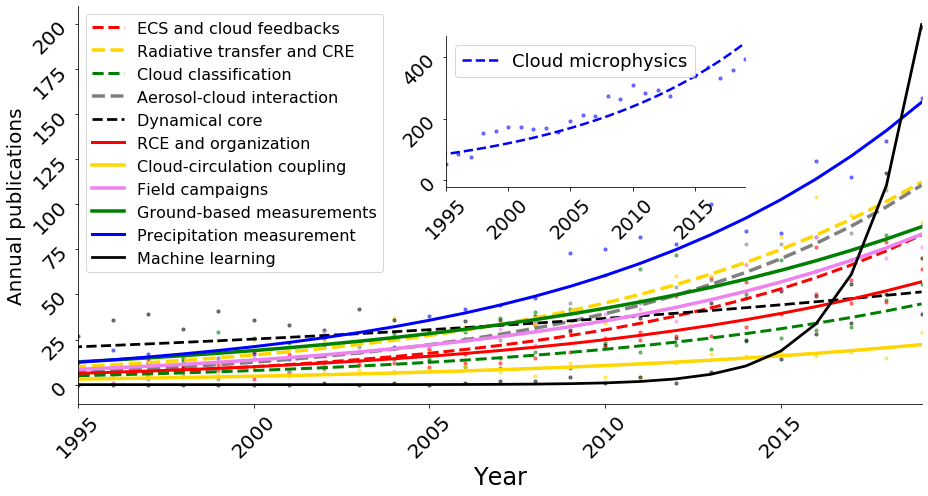

In [208]:
fig6 = plt.figure(figsize=(13,7))
f6_ax = fig6.gca()

# Colorblind cycle from https://gist.github.com/thriveth/8560036
farbe = ['red','gold','green','blue','gray','black','red','gold','gray',\
        'violet','green','blue','black']
lw = [2,2.5,2,2,2.5,1.75,2,2.5,2,2.5,2.5,2,1.75]
ls = ['--','--','--','--','--','--','-','-','-','-','-','-','-']
lbl = ['ECS and cloud feedbacks','Radiative transfer and CRE','Cloud classification',\
        'Cloud microphysics','Aerosol-cloud interaction','Dynamical core','RCE and organization',\
        'Cloud-circulation coupling','Multiscale studies','Field campaigns','Ground-based measurements',\
        'Precipitation measurement','Machine learning']
xx = np.arange(50)
for i in np.arange(len(subthemes)):
    if i == 3 or i == 8:
        continue
    else:
        f6_ax.scatter(np.arange(1970,2020),subtheme_count[:,i],c=farbe[i],s=10,alpha=0.5)
        pars, _ = curve_fit(f=exponential, xdata=xx, ydata=subtheme_count[:,i])
        f6_ax.plot(np.arange(1970,2020),pars[0]*2**(pars[1]*xx),linestyle=ls[i],linewidth=lw[i]+1,label=lbl[i],\
                 color=farbe[i])
        #print('Growth rate: ' + str(2**(pars[1])))

f6_ax.set_xlim([1995,2019])
f6_ax.legend(loc='upper left',fontsize=fs-4)
f6_ax.tick_params(axis='both',labelsize=fs,rotation=45)
f6_ax.set_ylabel('Annual publications',fontsize=fs)
f6_ax.set_xlabel('Year',fontsize=fs+4)
f6_ax.spines['top'].set_color('none')
f6_ax.spines['right'].set_color('none')

ax2 = plt.axes([0.48,0.62,0.32,0.3])
ax2.scatter(np.arange(1970,2020),subtheme_count[:,3],c=farbe[3],s=10,alpha=0.5)
pars, _ = curve_fit(f=exponential, xdata=xx, ydata=subtheme_count[:,3])
ax2.plot(np.arange(1970,2020),pars[0]*2**(pars[1]*xx),linestyle=ls[3],linewidth=lw[3]+0.5,label=lbl[3],\
                 color=farbe[3])
#print('Growth rate: ' + str(2**(pars[1])))
ax2.set_xlim([1995,2019])
ax2.tick_params(axis='both',labelsize=fs-1,rotation=45)
ax2.legend(loc='upper left',fontsize=fs-2)
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')

plt.tight_layout()
#fig6.savefig('publications-by-chapter.pdf')

# Fig 7: Bar and pie charts of techniques

In [213]:
scopus1 = pd.read_csv('scopus-cloud-climate-abstract-1.csv')
scopus2 = pd.read_csv('scopus-cloud-climate-abstract-2.csv')
scopus3 = pd.read_csv('scopus-cloud-climate-abstract-3.csv')
scopus4 = pd.read_csv('scopus-cloud-climate-abstract-4.csv')
scopus5 = pd.read_csv('scopus-cloud-climate-abstract-5.csv')
scopus6 = pd.read_csv('scopus-cloud-climate-abstract-6.csv')
scopus = pd.concat([scopus3, scopus2, scopus1, scopus4, scopus5],axis=0)

abstracts = scopus.iloc[:,5]
tech_names = ['In-situ measurement','Modeling','Reanalysis / Emissions','Remote sensing',
             'Ground-based measurement','Laboratory studies','Non-specified observations']
techniques = [['in-situ','flight','campaign','aircraft','rocket','drone'],
              ['model','parameterization','simulation','GCM','trajector','radiative transfer'],
              ['reanalys','emission'],
              ['satellite','CERES','TRMM','ISCCP','remote sens','retrieval','remote-sens','imager',
              'CALIPSO','CloudSat','MODIS','mission'],
              ['ground-based','station','meteorological observator','rain gauge',
               'site','SHEBA','flux tower'],
              ['laboratory','chamber','chemical characteriz'],'observation']

# For the sublists in techniques, query whether the abstract has any of its words.
# If so, add one to the corresponding counter. 
# tech_list stores which combinations of techniques are most common.
counter = np.zeros((len(techniques),))
tech_list = [[] for i in np.arange(len(abstracts))]
blist = []
model_abs_list = []
for total, i in enumerate(abstracts):
    b = 0
    for indx, j in enumerate(techniques):
        if isinstance(j,list) == False and re.search(j, i, re.IGNORECASE):
            counter[indx] = counter[indx] + 1
            tech_list[total].append(str(int(indx) + 1))
            b = b + 1
        elif isinstance(j,list) == True and any(re.search(jsub, i, re.IGNORECASE) for jsub in j):
            counter[indx] = counter[indx] + 1
            tech_list[total].append(str(int(indx) + 1))
            b = b + 1
            
        # Perform an additional filtering on abstracts that use modeling.
        if indx == 1:
            model_abs_list.append(i)
            
    # How many techniques were assigned to this abstract?        
    if i != '[No abstract available]':
        blist.append(b)
    if b == 0:
        tech_list[total].append('None')

# Print the percentage of abstracts assigned to techniques
for i in np.arange(len(techniques)):
    print(tech_names[i] + ': ' + str(counter[i]/total*100))
print('Average number of techniques assigned to an abstract: ' + str(sum(blist)/len(blist)))
print('Percent of abstracts with no assigned techniques: ' + str(len([b for b in blist if b == 0 ])/len(blist)*100.))

In-situ measurement: 8.227152899824253
Modeling: 67.91520210896309
Reanalysis / Emissions: 15.740333919156416
Remote sensing: 41.15773286467487
Ground-based measurement: 25.13181019332162
Laboratory studies: 2.899824253075571
Non-specified observations: 35.20430579964851
Average number of techniques assigned to an abstract: 1.9688188629352137
Percent of abstracts with no assigned techniques: 8.550022036139268


In [214]:
# Convert the tech_list entries into unique identifier codes.
tech_list_id = ["" for i in np.arange(len(tech_list))]
for indx, t in enumerate(tech_list):
    if t != 'None':
        tech_list_id[indx] = "".join(t)
    else:
        tech_list_id[indx] = t
        
# Remap the generic observational labels to their specific kind of observation.
remap_dict = {'247':'24','2457':'245','257':'25','2347':'234','247':'24','57':'5',
              '457':'45','23457':'2345','127':'12','1467':'146','1257':'125',
              '17':'1','67':'7','234567':'23456','1267':'126','12567':'1256','1237':'123',
              '567':'56','1457':'145','47':'4','12347':'1234','2567':'256','267':'26',
              '357':'35','12357':'1235','24567':'2456','3457':'345','14567':'1456',
              '1347':'134','4567':'456','467':'46','267':'26','13457':'1345','2357':'235',
              '2467':'246','12467':'1246','347':'34','23467':'2346','123467':'12346',
              '147':'14','123457':'12345','12467':'1246','12457':'1245','1247':'124','157':'15'} 
tech_list_id2 = [remap_dict[item] if item in remap_dict else item for item in tech_list_id]
lbl_dict = {'2345':'All except lab','24':'Model-Satellite','4':'Satellite','2':'Model','5':'Ground',
            'None':'Unclassified','27':'Model-Obs','7':'Observations','25':'Model-Ground','245':'Model-Satellite-Ground',
            '34':'Reanalysis-Satellite','45':'Satellite-Ground','234':'Model-Reanalysis-Ground',
            '124':'Flight-Model-Satellite','12':'Flight-Model','Residual':'Residual'}
color_dict = {'2345':'#dcbeff','24':'#bfef45','4':'#3cb44b','2':'#f58231','5':'#4363d8',
            'None':'#ffffff','27':'#9A6324','7':'#f032e6','25':'#42d4f4','245':'#aaffc3',
            '34':'#ffe119','45':'#469990','234':'#808000','124':'#ffd8b1','12':'#e6194B',
             'Residual':'#a9a9a9'}

# Calculate the percentage of abstracts belonging to each of the unique identifiers.
# Residual captures all those combinations with < 1% of abstracts.
residual = 0
piece_of_pie = []
print(sorted(set(tech_list_id2)))
for elem in sorted(set(tech_list_id2)):
    perc = len([t for t in tech_list_id2 if t == elem])/len(tech_list_id2)*100.
    if perc > 1:
        piece_of_pie.append([elem,perc])
    else:
        residual = residual + perc
piece_of_pie.append(['Residual',residual])

print(sum([p[1] for p in piece_of_pie]))
print(residual)

['1', '12', '123', '1234', '12345', '12346', '1235', '124', '1245', '1246', '125', '1256', '126', '13', '134', '1345', '13456', '1346', '14', '145', '1456', '146', '15', '156', '16', '2', '23', '234', '2345', '23456', '2346', '235', '236', '237', '24', '245', '2456', '246', '25', '256', '26', '27', '3', '34', '345', '3456', '346', '35', '36', '37', '4', '45', '456', '46', '5', '56', '6', '7', 'None']
99.99999999999997
11.125755079626579


In [215]:
# Filter the model abstracts for subtopics
model_filters = [['cloud-resolving','cloud resolving'],\
                 ['LEM','LES','eddy simulation'],
                 ['global climate model','global circulation model','GCM'],\
                 'trajector',['idealized','RCE'],['parcel model','process model'],\
                 ['limited-area','regional model'],'radiative transfer','high-resolution']
counter2 = np.zeros((len(model_filters),))
blist = []
for total, i in enumerate(model_abs_list):
    b = 0
    for indx, j in enumerate(model_filters):
        if isinstance(j,list) == False and indx != 1 and re.search(j, i, re.IGNORECASE):
            counter2[indx] = counter2[indx] + 1
            b = b + 1
        # For RCE and LEM / LES we have to retain the upper-case specification.
        elif isinstance(j,list) == True and indx != 1 and indx != 4 and any(re.search(jsub, i, re.IGNORECASE) for jsub in j):
            counter2[indx] = counter2[indx] + 1
            b = b + 1
        elif isinstance(j,list) == True and (indx == 1 or indx == 4) and any(jsub in i for jsub in j):
            counter2[indx] = counter2[indx] + 1
            b = b + 1
            
    # How many techniques were assigned to this abstract?        
    if i != '[No abstract available]':
        blist.append(b)
print(len([bb for bb in blist if bb != 0]))
print(counter2/len([bb for bb in blist if bb != 0])*100.)
print(sum(counter2)/len(model_abs_list)*100.)

2316
[ 9.7582038   5.82901554 45.89810017  6.43350604  9.19689119  2.59067358
  4.49050086 18.09153713 13.29879102]
29.401427786930256


[ 8.2271529  67.91520211 15.74033392 41.15773286 25.13181019  2.89982425
 35.2043058 ]
[ 9.7582038   5.82901554 45.89810017  6.43350604  9.19689119  2.59067358
  4.49050086 18.09153713 13.29879102]
16


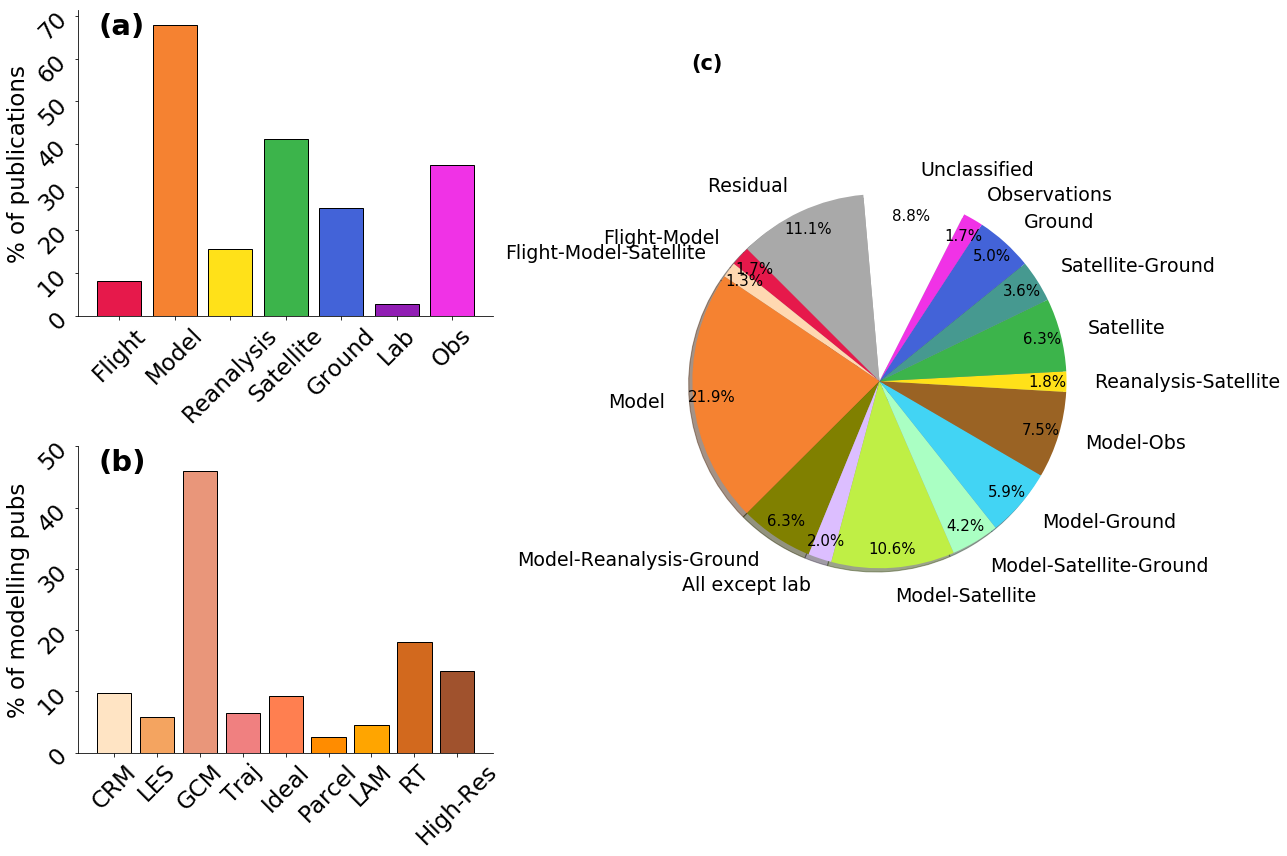

In [218]:
fs = 23
tech_names = ['Flight','Model','Reanalysis','Satellite','Ground','Lab','Obs']
farbe1 = ['#e6194B','#f58231','#ffe119','#3cb44b','#4363d8','#911eb4','#f032e6']

fig7 = plt.figure(figsize=(18,12))
gs = fig7.add_gridspec(2,2)
f7_ax1 = fig7.add_subplot(gs[0, 0])
f7_ax1.bar(np.arange(len(tech_names)),counter/total*100,color=farbe1,edgecolor='k')
print(counter/total*100)
f7_ax1.set_ylabel('% of publications',fontsize=fs)
f7_ax1.set_yticklabels([0,10,20,30,40,50,60,70],rotation=45,fontsize=fs)
f7_ax1.set_xticks(np.arange(len(tech_names)))
f7_ax1.set_xticklabels(tech_names,rotation=45,fontsize=fs)
f7_ax1.spines['right'].set_color('none')
f7_ax1.spines['top'].set_color('none')
f7_ax1.text(0.05,0.92,'(a)',fontsize=fs+6,weight='bold',color='k',transform=f7_ax1.transAxes)

#model_names = ['Cloud-resolving','Large-eddy','Global climate','Trajectory',\
#             'Idealized','Parcel','Limited-area','Radiative transfer','High-resolution']
model_names = ['CRM','LES','GCM','Traj','Ideal','Parcel','LAM','RT','High-Res']
farbe2 = ['bisque','sandybrown','darksalmon','lightcoral','coral',
         'darkorange','orange','chocolate','sienna']

f7_ax2 = fig7.add_subplot(gs[1, 0])
f7_ax2.bar(np.arange(len(model_filters)),counter2/len([bb for bb in blist if bb != 0])*100.,color=farbe2,edgecolor='k')
print(counter2/len([bb for bb in blist if bb != 0])*100.)
f7_ax2.set_yticks([0,10,20,30,40,50])
f7_ax2.set_yticklabels([0,10,20,30,40,50],rotation=45,fontsize=fs)
f7_ax2.set_xticks(np.arange(len(model_filters)))
f7_ax2.set_xticklabels(model_names,rotation=45,fontsize=fs)
f7_ax2.set_ylabel('% of modelling pubs',fontsize=fs)
f7_ax2.text(0.05,0.92,'(b)',fontsize=fs+6,weight='bold',color='k',transform=f7_ax2.transAxes)
f7_ax2.spines['right'].set_color('none')
f7_ax2.spines['top'].set_color('none')

fs = 15
f7_ax3 = fig7.add_subplot(gs[:, 1])
print(len([p[1] for p in piece_of_pie]))
wedges, txt, atxt = plt.pie([p[1] for p in piece_of_pie],labels=[lbl_dict[p[0]] for p in piece_of_pie],
                            shadow=True,colors=[color_dict[p[0]] for p in piece_of_pie],pctdistance=0.9,
                            labeldistance=1.15,autopct='%1.1f%%',startangle=135,rotatelabels=False)
f7_ax3.text(0.05,0.92,'(c)',fontsize=fs+6,weight='bold',color='k',transform=f7_ax3.transAxes)
plt.gca().axis('equal');
[ _.set_fontsize(fs+4) for _ in txt];
[ _.set_fontsize(fs) for _ in atxt];
plt.tight_layout(pad=1.08)

#fig7.savefig('techniques2.pdf',bbox_inches='tight')
plt.show()

# Fig 8: Author networks by theme

In [219]:
# Import some new packages to build a network.
from collections import Counter
from itertools import combinations
import networkx as nx
from nxviz.plots import CircosPlot
from random import sample
from matplotlib import pylab
print(nx.__version__)

2.3


In [220]:
# Extract author connections. Taking from the following:
# https://towardsdatascience.com/network-analysis-to-quickly-get-insight-into-an-academic-field-with-python-cd891717d547
def author_graph(fi,yr1,yr2):
    scopus = pd.read_csv(fi)
    scopus = scopus[(scopus.Year > yr1) & (scopus.Year <= yr2)]
    authors = scopus['Author(s) ID']
    #authors_flat = [b.strip() for a in list(authors) for b in a.split(';')]

    # Create all 2/pair combinations of authors from dataframe field above.
    author_connections = list(
        map(lambda x: list(combinations(x.split(';'),2)), authors))
    # Remove empty strings in the list.
    author_connections = [list(filter(lambda t: '' not in t, l2)) for l2 in author_connections]
    flat_connections = [item for sublist in author_connections for item in sublist]

    # Create a dataframe from the connections above.
    connx = pd.DataFrame(flat_connections,columns=['From','To'])
    connx_graph = connx.groupby(["From", "To"]).size().reset_index()
    connx_graph.columns = ["From", "To", "Count"]

    # Create a graph from the connections dataframe. 
    G = nx.from_pandas_edgelist(connx_graph, source="From", target="To", edge_attr="Count")
    print('Number of nodes: ' + str(G.number_of_nodes()) + ', Number of edges: ' + str(G.number_of_edges()))
    return G

In [221]:
# Function to visualize a large graph without memory error.
# Taken from https://stackoverflow.com/questions/17381006/
# Kamada-Kawai path-length cost-function or Fruchterman-Reingold layout (spring)
# F-R is force-directed graph drawing, seeking to "position the nodes in 2D space 
# so that all edges are of equal length with as few crossing edges as possible."
def save_graph(graphs,file_name,nc):
    # initialize Figure
    c = int(np.ceil(len(graphs)/nc))
    letra = ['(' + a + ')' for a in string.ascii_lowercase[:len(graphs)]]
    fig, axes = plt.subplots(nrows=c, ncols=nc, figsize=(15,20),dpi=300)
    for ax, g, let in zip(axes.flatten(), graphs, letra):
        pos = nx.circular_layout(g)   #circle_layout
        d = dict(g.degree)
        nx.draw_networkx_nodes(g,pos,nodelist=d.keys(),node_size=[v*50 for v in d.values()],
                           node_color=[v for v in d.values()],alpha=0.5,ax=ax,cmap=cm.jet,linewidths=1)
        nx.draw_networkx_edges(g,pos,ax=ax)
        ax.text(0.05,0.93,let,weight='bold',fontsize=15,transform=ax.transAxes)
        ax.axis('off')
    
    #plt.savefig(file_name,bbox_inches='tight')
    pylab.close()
    del fig

In [222]:
def save_graph2(graphs,file_name,nc):
    # initialize Figure
    c = int(np.ceil(len(graphs)/nc))
    letra = ['(' + a + ')' for a in string.ascii_lowercase[:len(graphs)]]
    fig, axes = plt.subplots(nrows=1, ncols=nc, figsize=(12,5),dpi=300)
    for ax, g, let in zip(axes.flatten(), graphs, letra):
        pos = nx.circular_layout(g)   #circle_layout
        d = dict(g.degree)
        nx.draw_networkx_nodes(g,pos,nodelist=d.keys(),node_size=[v*50 for v in d.values()],
                           node_color=[v for v in d.values()],alpha=0.5,ax=ax,cmap=cm.jet,linewidths=1)
        nx.draw_networkx_edges(g,pos,ax=ax)
        ax.text(0.05,0.93,let,weight='bold',fontsize=15,transform=ax.transAxes)
        ax.axis('off')
    
    #plt.savefig(file_name,bbox_inches='tight')
    pylab.close()
    del fig

In [223]:
# Use the two functions above to generate network plots for each theme and different time periods
G1 = author_graph('clouds-climate-radiation.csv',1988,1989)
G2 = author_graph('clouds-climate-radiation.csv',1998,1999)
G3 = author_graph('clouds-climate-circulation.csv',1988,1989)
G4 = author_graph('clouds-climate-circulation.csv',1998,1999)
G5 = author_graph('clouds-climate-precipitation.csv',1988,1989)
G6 = author_graph('clouds-climate-precipitation.csv',1998,1999)
#save_graph([G1,G2,G3,G4,G5,G6],'author-network-by-theme.pdf',2)
#save_graph2([G1,G2],'author-network-over-time.pdf',2)

print(nx.info(G1))
print(nx.info(G2))
print(nx.info(G3))
print(nx.info(G4))
print(nx.info(G5))
print(nx.info(G6))
print(nx.density(G1),nx.density(G2))
print(nx.density(G3),nx.density(G4))
print(nx.density(G5),nx.density(G6))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

Number of nodes: 21, Number of edges: 16
Number of nodes: 294, Number of edges: 551
Number of nodes: 10, Number of edges: 9
Number of nodes: 137, Number of edges: 282
Number of nodes: 9, Number of edges: 21
Number of nodes: 144, Number of edges: 196
Name: 
Type: Graph
Number of nodes: 21
Number of edges: 16
Average degree:   1.5238
Name: 
Type: Graph
Number of nodes: 294
Number of edges: 551
Average degree:   3.7483
Name: 
Type: Graph
Number of nodes: 10
Number of edges: 9
Average degree:   1.8000
Name: 
Type: Graph
Number of nodes: 137
Number of edges: 282
Average degree:   4.1168
Name: 
Type: Graph
Number of nodes: 9
Number of edges: 21
Average degree:   4.6667
Name: 
Type: Graph
Number of nodes: 144
Number of edges: 196
Average degree:   2.7222
0.0761904761904762 0.012792830442757308
0.2 0.03027050236152855
0.5833333333333334 0.019036519036519036
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [137]:
print('NETWORK INFO AND DENSITY FOR 2019 BY THEME')
G1 = author_graph('clouds-climate-radiation.csv',2018,2019)
G2 = author_graph('clouds-climate-circulation.csv',2018,2019)
G3 = author_graph('clouds-climate-precipitation.csv',2018,2019)

print(nx.info(G1))
print(nx.density(G1))
# Return the list of components and extract the largest.
comp = nx.connected_components(G1)
G1_sub = G1.subgraph(max(comp,key=len))
print(nx.diameter(G1_sub))
print(comp)
#print(max(comp,key=len))
#print(nx.info(G2))
#print(nx.density(G2))
#print(nx.info(G3))
#print(nx.density(G3))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

#print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

NETWORK INFO AND DENSITY FOR 2019 BY THEME
Number of nodes: 1929, Number of edges: 11265
Number of nodes: 750, Number of edges: 3798
Number of nodes: 1269, Number of edges: 5025
Name: 
Type: Graph
Number of nodes: 1929
Number of edges: 11265
Average degree:  11.6796
0.006057897691707052
12
<generator object connected_components at 0x2b42cadaef68>
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Fig 7: Author networks by chapter

In [138]:
### Function to visualize a large graph without memory error. Same as above but different layout
def save_graph3(graphs,file_name,nc,topics):
    # initialize Figure
    c = int(np.ceil(len(graphs)/nc))
    letra = ['(' + a + ')' for a in string.ascii_lowercase[:len(graphs)]]
    fig, axes = plt.subplots(nrows=c, ncols=nc, figsize=(15.5,15.5),dpi=300)
    for ax, g, let, topic in zip(axes.flatten(), graphs, letra, topics):
        pos = nx.spring_layout(g)
        d = dict(g.degree)
        nx.draw_networkx_nodes(g,pos,nodelist=d.keys(),node_size=[v*50 for v in d.values()],
                           node_color=[v for v in d.values()],alpha=0.5,ax=ax,cmap=cm.jet,linewidths=1)
        nx.draw_networkx_edges(g,pos,ax=ax)
        ax.text(0.05,1.06,let ,weight='bold',fontsize=20,transform=ax.transAxes)
        ax.text(0.05,1,topic,fontsize=18,transform=ax.transAxes)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['bottom'].set_color('none')
    
    #plt.savefig(file_name,bbox_inches='tight')
    pylab.close()
    del fig

In [139]:
G_list = []
for chapter in [2,8,15,3,10,16,4,13,18]:#np.arange(2,19):
    G = author_graph('chapter' + str(chapter) + '-scopus.csv',2015,2016)
    G_list.append(G)
    
#save_graph3(G_list,'author-network-by-chapter.pdf',3)

Number of nodes: 316, Number of edges: 1474
Number of nodes: 196, Number of edges: 702
Number of nodes: 629, Number of edges: 1789
Number of nodes: 262, Number of edges: 741
Number of nodes: 71, Number of edges: 209
Number of nodes: 174, Number of edges: 428
Number of nodes: 161, Number of edges: 513
Number of nodes: 70, Number of edges: 129
Number of nodes: 76, Number of edges: 169


In [140]:
G_list = []
subthemes = ['-1-ECS-cloud-feedbacks','-2-radiative-transfer-CRE','-5-aerosol-cloud-interactions-AIE',\
            '-6-primitive-equations-dynamical-core','-7-RCE-convective-organization',\
            '-10-cloud-field-campaign','-11-cloud-ground-based-measurement',
             '-12-cloud-precipitation-measurement','-13-cloud-machine-learning-causal-inference']
lbl = ['ECS and cloud feedbacks','Radiative transfer and CRE','Aerosol-cloud interaction',\
       'Dynamical core','RCE and organization','Field campaigns','Ground-based measurements',\
        'Precipitation measurement','Machine learning']
deg = [[] for i in np.arange(len(lbl))]
for sindx, s in enumerate(subthemes[:9]):
    G = author_graph('scopus' + s + '.csv',2015,2016)
    G_list.append(G)
    deg[sindx].extend([j[1] for j in sorted(G.degree, key=lambda x: x[1], reverse=True)[:]])
    print(deg[sindx][:25])
    
save_graph3(G_list,'author-network-by-subtheme.pdf',3,lbl)

Number of nodes: 244, Number of edges: 699
[22, 20, 20, 17, 16, 15, 14, 13, 13, 13, 13, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
Number of nodes: 437, Number of edges: 1525
[18, 18, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 14, 14, 14]
Number of nodes: 412, Number of edges: 2003
[38, 35, 35, 34, 34, 34, 33, 33, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28]
Number of nodes: 152, Number of edges: 485
[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 16, 9]
Number of nodes: 152, Number of edges: 369
[15, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Number of nodes: 592, Number of edges: 4403
[56, 55, 54, 53, 49, 49, 49, 49, 49, 49, 48, 47, 45, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
Number of nodes: 392, Number of edges: 1970
[33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]


/pf/b/b380873/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
